# Effects of Parameters in the GM Model

By keeping the domain (40 X 40 square), the initial condition (random numbers in the activator component matrix U), and all other parameters constant, we searched for the range of one specific parameter at one time that renders a stable ending state pattern. We visualized the **initial condition** and **the ending state patterns for 8 different values in the search range of each parameter** in the model. 

We chose to use ADI method to compute the solution for the PDE equations since it is comparatively the most accurate (2-nd order) and the most stable (allows the largest dt) among all the 4 methods we tried.

In [1]:
# import libraries
import numpy as np
from util import *
import scipy.sparse as sparse
import scipy.sparse.linalg as linalg
import time
from IPython.display import HTML
%matplotlib inline

## Base Model Parameters Setup

```python
Du = 0.02 # diffusion rate of u
Dv = 2 # diffusion rate of v
rho = 0.001 # source density
rho_u = 0.001 # basic activator production rate
mu_u = 0.02 # decay rate of u
mu_v = 0.03 # decay rate of v
kappa = 0.1 # saturation constanct
```

## Change `Du`, `Dv`

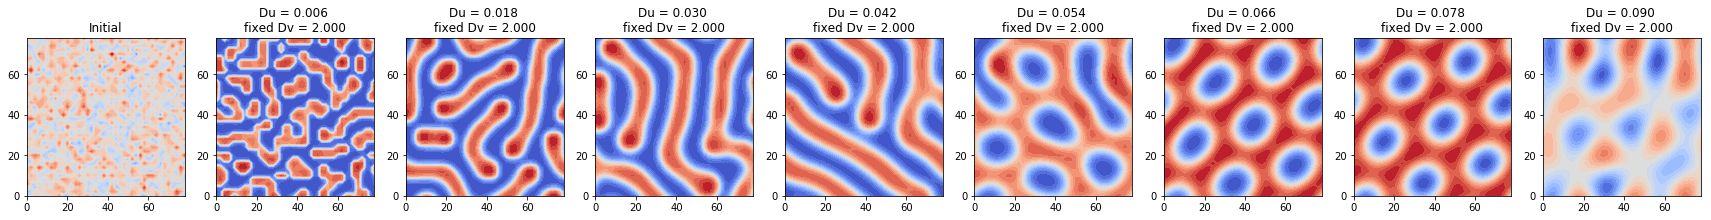

In [2]:
# Grid setup
Ny, Nx = 40, 40
h = 2
N = Nx * Ny

# Parameters setup
Du_arr = np.linspace(0.006, 0.090, 8)
Dv = 2
rho = 0.001
rho_u = 0.001
mu_u = 0.02
mu_v = 0.03
kappa = 0.1

# Time steps
dt = 20
end_t = 10000
time_steps = int(end_t / dt)
c = dt / (h * h)

# Initial conditions
U_init = np.random.normal(0.5, 0.1, (Ny, Nx))
V_init = 0.1 * np.ones((Ny, Nx))

# The array that records each ending state with the specific parameter value
U_ends = np.zeros((len(Du_arr)+1, Ny, Nx))
U_ends[0] = np.copy(U_init)

# The array of all plots' titles
titles = []
titles.append('Initial')

# For each Du, generate pattern and save the ending state
for idx, Du in enumerate(Du_arr):
    # Construct transform matrices
    D2x = sparse.diags([-2, 1, 1, 1, 1], [0, 1, -1, 1 - Nx, -1 + Nx], shape=(Nx, Nx))
    D2y = sparse.diags([-2, 1, 1, 1, 1], [0, 1, -1, 1 - Ny, -1 + Ny], shape=(Ny, Ny))
    Tu_x = sparse.eye(Nx) - 0.5 * Du * c * D2x
    Tu_y = sparse.eye(Ny) - 0.5 * Du * c * D2y
    Tv_x = sparse.eye(Nx) - 0.5 * Dv * c * D2x
    Tv_y = sparse.eye(Ny) - 0.5 * Dv * c * D2y

    # Factorize matrices
    solve_Tu_x = linalg.factorized(Tu_x.tocsc())
    solve_Tu_y = linalg.factorized(Tu_y.tocsc())
    solve_Tv_x = linalg.factorized(Tv_x.tocsc())
    solve_Tv_y = linalg.factorized(Tv_y.tocsc())
    
    # Initial conditions
    U = np.zeros((time_steps, Ny, Nx))
    V = np.zeros((time_steps, Ny, Nx))
    U[0] = np.copy(U_init)
    V[0] = np.copy(V_init)
    
    for i in range(1, time_steps):
        # Stage one - solve along x direction
        b1U = 0.5 * Du * c * D2y.dot(U[i - 1]) + 0.5 * dt * rho/V[i - 1] * U[i - 1]**2 / (1 + kappa*U[i - 1]**2) \
            + (1 - 0.5 * dt * mu_u) * U[i - 1] + 0.5 * dt * rho_u
        b1V = 0.5 * Dv * c * D2y.dot(V[i - 1]) \
            + 0.5 * dt * rho * U[i - 1]**2 / (1 + kappa*U[i - 1]**2) + (1 - 0.5 * dt * mu_v) * V[i - 1]

        U_middle = solve_Tu_x(b1U.T)
        V_middle = solve_Tv_x(b1V.T)

        # Stage two - solve along y direction
        b2U = 0.5 * Du * c * D2x.dot(U_middle) + 0.5 * dt * rho/V_middle * U_middle**2 / (1 + kappa*U_middle**2) \
            + (1 - 0.5 * dt * mu_u) * U_middle + 0.5 * dt * rho_u
        b2V = 0.5 * Dv * c * D2x.dot(V_middle) \
            + 0.5 * dt * rho * U_middle**2 / (1 + kappa*U_middle**2) + (1 - 0.5 * dt * mu_v) * V_middle

        U[i] = solve_Tu_y(b2U.T)
        V[i] = solve_Tv_y(b2V.T)
    
    U_ends[idx + 1] = U[-1]
    titles.append('Du = %.3f \nfixed Dv = %.3f' % (Du_arr[idx], Dv))

plot_pattern_end_states(U_ends, titles, h)

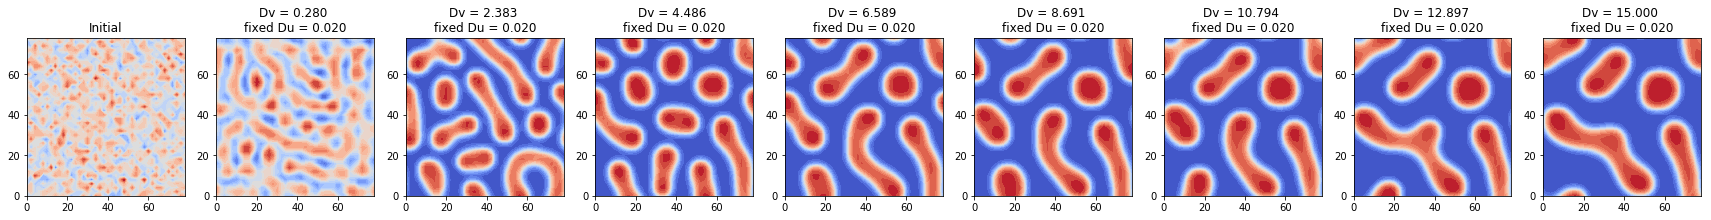

In [3]:
# Grid setup
Ny, Nx = 40, 40
h = 2
N = Nx * Ny

# Parameters setup
Du = 0.02
Dv_arr = np.linspace(0.28, 15, 8)
rho = 0.001
rho_u = 0.001
mu_u = 0.02
mu_v = 0.03
kappa = 0.1

# Time steps
dt = 20
end_t = 10000
time_steps = int(end_t / dt)
c = dt / (h * h)

# Initial conditions
U_init = np.random.normal(0.5, 0.1, (Ny, Nx))
V_init = 0.1 * np.ones((Ny, Nx))

# The array that records each ending state with the specific parameter value
U_ends = np.zeros((len(Dv_arr)+1, Ny, Nx))
U_ends[0] = np.copy(U_init)

# The array of all plots' titles
titles = []
titles.append('Initial')

# For each Dv, generate pattern and save the ending state
for idx, Dv in enumerate(Dv_arr):
    # Construct transform matrices
    D2x = sparse.diags([-2, 1, 1, 1, 1], [0, 1, -1, 1 - Nx, -1 + Nx], shape=(Nx, Nx))
    D2y = sparse.diags([-2, 1, 1, 1, 1], [0, 1, -1, 1 - Ny, -1 + Ny], shape=(Ny, Ny))
    Tu_x = sparse.eye(Nx) - 0.5 * Du * c * D2x
    Tu_y = sparse.eye(Ny) - 0.5 * Du * c * D2y
    Tv_x = sparse.eye(Nx) - 0.5 * Dv * c * D2x
    Tv_y = sparse.eye(Ny) - 0.5 * Dv * c * D2y

    # Factorize matrices
    solve_Tu_x = linalg.factorized(Tu_x.tocsc())
    solve_Tu_y = linalg.factorized(Tu_y.tocsc())
    solve_Tv_x = linalg.factorized(Tv_x.tocsc())
    solve_Tv_y = linalg.factorized(Tv_y.tocsc())
    
    # Initial conditions
    U = np.zeros((time_steps, Ny, Nx))
    V = np.zeros((time_steps, Ny, Nx))
    U[0] = np.copy(U_init)
    V[0] = np.copy(V_init)
    
    for i in range(1, time_steps):
        # Stage one - solve along x direction
        b1U = 0.5 * Du * c * D2y.dot(U[i - 1]) + 0.5 * dt * rho/V[i - 1] * U[i - 1]**2 / (1 + kappa*U[i - 1]**2) \
            + (1 - 0.5 * dt * mu_u) * U[i - 1] + 0.5 * dt * rho_u
        b1V = 0.5 * Dv * c * D2y.dot(V[i - 1]) \
            + 0.5 * dt * rho * U[i - 1]**2 / (1 + kappa*U[i - 1]**2) + (1 - 0.5 * dt * mu_v) * V[i - 1]

        U_middle = solve_Tu_x(b1U.T)
        V_middle = solve_Tv_x(b1V.T)

        # Stage two - solve along y direction
        b2U = 0.5 * Du * c * D2x.dot(U_middle) + 0.5 * dt * rho/V_middle * U_middle**2 / (1 + kappa*U_middle**2) \
            + (1 - 0.5 * dt * mu_u) * U_middle + 0.5 * dt * rho_u
        b2V = 0.5 * Dv * c * D2x.dot(V_middle) \
            + 0.5 * dt * rho * U_middle**2 / (1 + kappa*U_middle**2) + (1 - 0.5 * dt * mu_v) * V_middle

        U[i] = solve_Tu_y(b2U.T)
        V[i] = solve_Tv_y(b2V.T)
    
    U_ends[idx + 1] = U[-1]
    titles.append('Dv = %.3f \nfixed Du = %.3f' % (Dv_arr[idx], Du))

plot_pattern_end_states(U_ends, titles, h)

**Observation**: To get a stable pattern modeled by GM model, we must have Du << Dv (diffusion rate of the activator U should be much smaller than the the diffusion rate of the inhibitor V): 

- when fix Dv = 2, Du $\sim$ (0.006, 0.090); 

- when fix Du = 0.02, Dv > 0.28.

## Change $\rho$

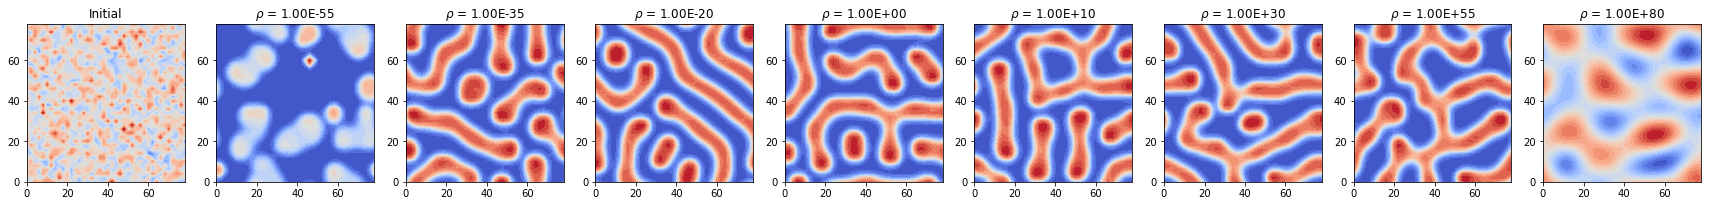

In [4]:
# Grid setup
Ny, Nx = 40, 40
h = 2
N = Nx * Ny

# Parameters setup
Du = 0.02
Dv = 2
rho_list = [1e-55, 1e-35, 1e-20, 1, 1e10, 1e30, 1e55, 1e80]
rho_u = 0.001
mu_u = 0.02
mu_v = 0.03
kappa = 0.1

# Time steps
dt = 20
end_t = 10000
time_steps = int(end_t / dt)
c = dt / (h * h)

# Construct transform matrices
D2x = sparse.diags([-2, 1, 1, 1, 1], [0, 1, -1, 1 - Nx, -1 + Nx], shape=(Nx, Nx))
D2y = sparse.diags([-2, 1, 1, 1, 1], [0, 1, -1, 1 - Ny, -1 + Ny], shape=(Ny, Ny))
Tu_x = sparse.eye(Nx) - 0.5 * Du * c * D2x
Tu_y = sparse.eye(Ny) - 0.5 * Du * c * D2y
Tv_x = sparse.eye(Nx) - 0.5 * Dv * c * D2x
Tv_y = sparse.eye(Ny) - 0.5 * Dv * c * D2y

# Factorize matrices
solve_Tu_x = linalg.factorized(Tu_x.tocsc())
solve_Tu_y = linalg.factorized(Tu_y.tocsc())
solve_Tv_x = linalg.factorized(Tv_x.tocsc())
solve_Tv_y = linalg.factorized(Tv_y.tocsc())

# Initial conditions
U_init = np.random.normal(0.5, 0.1, (Ny, Nx))
V_init = 0.1 * np.ones((Ny, Nx))

# The array that records each ending state with the specific parameter value
U_ends = np.zeros((len(rho_list)+1, Ny, Nx))
U_ends[0] = np.copy(U_init)

# The array of all plots' titles
titles = []
titles.append('Initial')

# For each rho, generate pattern and save the ending state
for idx, rho in enumerate(rho_list):
    # Initial conditions
    U = np.zeros((time_steps, Ny, Nx))
    V = np.zeros((time_steps, Ny, Nx))
    U[0] = np.copy(U_init)
    V[0] = np.copy(V_init)
    
    for i in range(1, time_steps):
        # Stage one - solve along x direction
        b1U = 0.5 * Du * c * D2y.dot(U[i - 1]) + 0.5 * dt * rho/V[i - 1] * U[i - 1]**2 / (1 + kappa*U[i - 1]**2) \
            + (1 - 0.5 * dt * mu_u) * U[i - 1] + 0.5 * dt * rho_u
        b1V = 0.5 * Dv * c * D2y.dot(V[i - 1]) \
            + 0.5 * dt * rho * U[i - 1]**2 / (1 + kappa*U[i - 1]**2) + (1 - 0.5 * dt * mu_v) * V[i - 1]

        U_middle = solve_Tu_x(b1U.T)
        V_middle = solve_Tv_x(b1V.T)

        # Stage two - solve along y direction
        b2U = 0.5 * Du * c * D2x.dot(U_middle) + 0.5 * dt * rho/V_middle * U_middle**2 / (1 + kappa*U_middle**2) \
            + (1 - 0.5 * dt * mu_u) * U_middle + 0.5 * dt * rho_u
        b2V = 0.5 * Dv * c * D2x.dot(V_middle) \
            + 0.5 * dt * rho * U_middle**2 / (1 + kappa*U_middle**2) + (1 - 0.5 * dt * mu_v) * V_middle

        U[i] = solve_Tu_y(b2U.T)
        V[i] = solve_Tv_y(b2V.T)
    
    U_ends[idx + 1] = U[-1]
    titles.append(r'$\rho$ = %.2E' % (rho_list[idx]))

plot_pattern_end_states(U_ends, titles, h)

**Observation**: When $\rho$ gets too large or too small, the solution of the GM model will be unstable:

- $\rho$ $\sim$ (`1e-55`, `1e80`)

## Change $\rho_u$

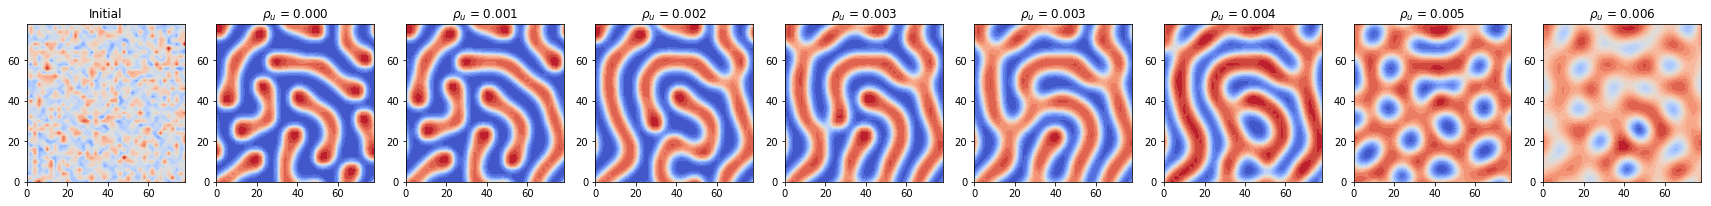

In [5]:
# Grid setup
Ny, Nx = 40, 40
h = 2
N = Nx * Ny

# Parameters setup
Du = 0.02
Dv = 2
rho = 0.001
rho_u_arr = np.linspace(0, 0.006, 8)
mu_u = 0.02
mu_v = 0.03
kappa = 0.1

# Time steps
dt = 20
end_t = 10000
time_steps = int(end_t / dt)
c = dt / (h * h)

# Construct transform matrices
D2x = sparse.diags([-2, 1, 1, 1, 1], [0, 1, -1, 1 - Nx, -1 + Nx], shape=(Nx, Nx))
D2y = sparse.diags([-2, 1, 1, 1, 1], [0, 1, -1, 1 - Ny, -1 + Ny], shape=(Ny, Ny))
Tu_x = sparse.eye(Nx) - 0.5 * Du * c * D2x
Tu_y = sparse.eye(Ny) - 0.5 * Du * c * D2y
Tv_x = sparse.eye(Nx) - 0.5 * Dv * c * D2x
Tv_y = sparse.eye(Ny) - 0.5 * Dv * c * D2y

# Factorize matrices
solve_Tu_x = linalg.factorized(Tu_x.tocsc())
solve_Tu_y = linalg.factorized(Tu_y.tocsc())
solve_Tv_x = linalg.factorized(Tv_x.tocsc())
solve_Tv_y = linalg.factorized(Tv_y.tocsc())

# Initial conditions
U_init = np.random.normal(0.5, 0.1, (Ny, Nx))
V_init = 0.1 * np.ones((Ny, Nx))

# The array that records each ending state with the specific parameter value
U_ends = np.zeros((len(rho_u_arr)+1, Ny, Nx))
U_ends[0] = np.copy(U_init)

# The array of all plots' titles
titles = []
titles.append('Initial')

# For each rho_u, generate pattern and save the ending state
for idx, rho_u in enumerate(rho_u_arr):
    # Initial conditions
    U = np.zeros((time_steps, Ny, Nx))
    V = np.zeros((time_steps, Ny, Nx))
    U[0] = np.copy(U_init)
    V[0] = np.copy(V_init)
    
    for i in range(1, time_steps):
        # Stage one - solve along x direction
        b1U = 0.5 * Du * c * D2y.dot(U[i - 1]) + 0.5 * dt * rho/V[i - 1] * U[i - 1]**2 / (1 + kappa*U[i - 1]**2) \
            + (1 - 0.5 * dt * mu_u) * U[i - 1] + 0.5 * dt * rho_u
        b1V = 0.5 * Dv * c * D2y.dot(V[i - 1]) \
            + 0.5 * dt * rho * U[i - 1]**2 / (1 + kappa*U[i - 1]**2) + (1 - 0.5 * dt * mu_v) * V[i - 1]

        U_middle = solve_Tu_x(b1U.T)
        V_middle = solve_Tv_x(b1V.T)

        # Stage two - solve along y direction
        b2U = 0.5 * Du * c * D2x.dot(U_middle) + 0.5 * dt * rho/V_middle * U_middle**2 / (1 + kappa*U_middle**2) \
            + (1 - 0.5 * dt * mu_u) * U_middle + 0.5 * dt * rho_u
        b2V = 0.5 * Dv * c * D2x.dot(V_middle) \
            + 0.5 * dt * rho * U_middle**2 / (1 + kappa*U_middle**2) + (1 - 0.5 * dt * mu_v) * V_middle

        U[i] = solve_Tu_y(b2U.T)
        V[i] = solve_Tv_y(b2V.T)

    U_ends[idx + 1] = U[-1]
    titles.append(r'$\rho_u$ = %.3f' % (rho_u_arr[idx]))

plot_pattern_end_states(U_ends, titles, h)

**Observation**: For stability, 

- $\rho_u$ $\sim$ (0, 0.006).

## Change $\mu_u$

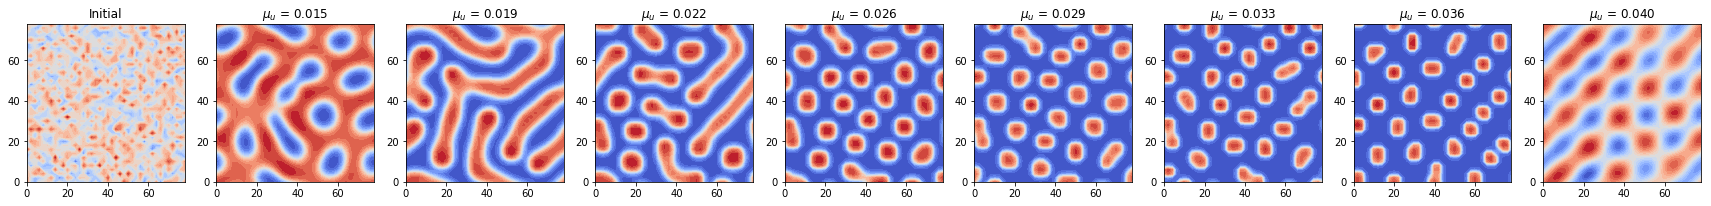

In [11]:
# Grid setup
Ny, Nx = 40, 40
h = 2
N = Nx * Ny

# Parameters setup
Du = 0.02
Dv = 2
rho = 0.001
rho_u = 0.001
mu_u_arr = np.linspace(0.015, 0.040, 8)
mu_v = 0.03
kappa = 0.1

# Time steps
dt = 20
end_t = 10000
time_steps = int(end_t / dt)
c = dt / (h * h)

# Construct transform matrices
D2x = sparse.diags([-2, 1, 1, 1, 1], [0, 1, -1, 1 - Nx, -1 + Nx], shape=(Nx, Nx))
D2y = sparse.diags([-2, 1, 1, 1, 1], [0, 1, -1, 1 - Ny, -1 + Ny], shape=(Ny, Ny))
Tu_x = sparse.eye(Nx) - 0.5 * Du * c * D2x
Tu_y = sparse.eye(Ny) - 0.5 * Du * c * D2y
Tv_x = sparse.eye(Nx) - 0.5 * Dv * c * D2x
Tv_y = sparse.eye(Ny) - 0.5 * Dv * c * D2y

# Factorize matrices
solve_Tu_x = linalg.factorized(Tu_x.tocsc())
solve_Tu_y = linalg.factorized(Tu_y.tocsc())
solve_Tv_x = linalg.factorized(Tv_x.tocsc())
solve_Tv_y = linalg.factorized(Tv_y.tocsc())

# Initial conditions
U_init = np.random.normal(0.5, 0.1, (Ny, Nx))
V_init = 0.1 * np.ones((Ny, Nx))

# The array that records each ending state with the specific parameter value
U_ends = np.zeros((len(mu_u_arr)+1, Ny, Nx))
U_ends[0] = np.copy(U_init)

# The array of all plots' titles
titles = []
titles.append('Initial')

# For each mu_u, generate pattern and save the ending state
for idx, mu_u in enumerate(mu_u_arr):
    # Initial conditions
    U = np.zeros((time_steps, Ny, Nx))
    V = np.zeros((time_steps, Ny, Nx))
    U[0] = np.copy(U_init)
    V[0] = np.copy(V_init)
    
    for i in range(1, time_steps):
        # Stage one - solve along x direction
        b1U = 0.5 * Du * c * D2y.dot(U[i - 1]) + 0.5 * dt * rho/V[i - 1] * U[i - 1]**2 / (1 + kappa*U[i - 1]**2) \
            + (1 - 0.5 * dt * mu_u) * U[i - 1] + 0.5 * dt * rho_u
        b1V = 0.5 * Dv * c * D2y.dot(V[i - 1]) \
            + 0.5 * dt * rho * U[i - 1]**2 / (1 + kappa*U[i - 1]**2) + (1 - 0.5 * dt * mu_v) * V[i - 1]

        U_middle = solve_Tu_x(b1U.T)
        V_middle = solve_Tv_x(b1V.T)

        # Stage two - solve along y direction
        b2U = 0.5 * Du * c * D2x.dot(U_middle) + 0.5 * dt * rho/V_middle * U_middle**2 / (1 + kappa*U_middle**2) \
            + (1 - 0.5 * dt * mu_u) * U_middle + 0.5 * dt * rho_u
        b2V = 0.5 * Dv * c * D2x.dot(V_middle) \
            + 0.5 * dt * rho * U_middle**2 / (1 + kappa*U_middle**2) + (1 - 0.5 * dt * mu_v) * V_middle

        U[i] = solve_Tu_y(b2U.T)
        V[i] = solve_Tv_y(b2V.T)
    
    U_ends[idx + 1] = U[-1]
    titles.append(r'$\mu_u$ = %.3f' % (mu_u_arr[idx]))

plot_pattern_end_states(U_ends, titles, h)

**Observation**: For stability,

- $\mu_u$ $\sim$ (0.015, 0.040).

## Change $\mu_v$

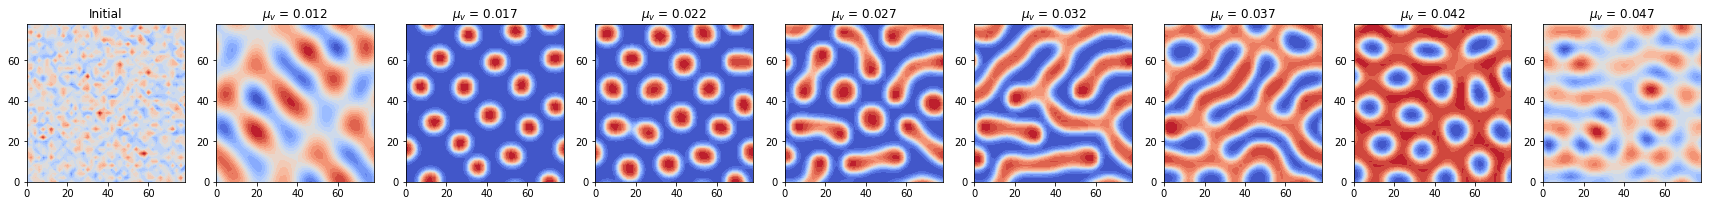

In [14]:
# Grid setup
Ny, Nx = 40, 40
h = 2
N = Nx * Ny

# Parameters setup
Du = 0.02
Dv = 2
rho = 0.001
rho_u = 0.001
mu_u = 0.02
mu_v_arr = np.linspace(0.012, 0.047, 8)
kappa = 0.1

# Time steps
dt = 20
end_t = 10000
time_steps = int(end_t / dt)
c = dt / (h * h)

# Construct transform matrices
D2x = sparse.diags([-2, 1, 1, 1, 1], [0, 1, -1, 1 - Nx, -1 + Nx], shape=(Nx, Nx))
D2y = sparse.diags([-2, 1, 1, 1, 1], [0, 1, -1, 1 - Ny, -1 + Ny], shape=(Ny, Ny))
Tu_x = sparse.eye(Nx) - 0.5 * Du * c * D2x
Tu_y = sparse.eye(Ny) - 0.5 * Du * c * D2y
Tv_x = sparse.eye(Nx) - 0.5 * Dv * c * D2x
Tv_y = sparse.eye(Ny) - 0.5 * Dv * c * D2y

# Factorize matrices
solve_Tu_x = linalg.factorized(Tu_x.tocsc())
solve_Tu_y = linalg.factorized(Tu_y.tocsc())
solve_Tv_x = linalg.factorized(Tv_x.tocsc())
solve_Tv_y = linalg.factorized(Tv_y.tocsc())

# Initial conditions
U_init = np.random.normal(0.5, 0.1, (Ny, Nx))
V_init = 0.1 * np.ones((Ny, Nx))

# The array that records each ending state with the specific parameter value
U_ends = np.zeros((len(mu_v_arr)+1, Ny, Nx))
U_ends[0] = np.copy(U_init)

# The array of all plots' titles
titles = []
titles.append('Initial')

# For each mu_v, generate pattern and save the ending state
for idx, mu_v in enumerate(mu_v_arr):
    # Initial conditions
    U = np.zeros((time_steps, Ny, Nx))
    V = np.zeros((time_steps, Ny, Nx))
    U[0] = np.copy(U_init)
    V[0] = np.copy(V_init)
    
    for i in range(1, time_steps):
        # Stage one - solve along x direction
        b1U = 0.5 * Du * c * D2y.dot(U[i - 1]) + 0.5 * dt * rho/V[i - 1] * U[i - 1]**2 / (1 + kappa*U[i - 1]**2) \
            + (1 - 0.5 * dt * mu_u) * U[i - 1] + 0.5 * dt * rho_u
        b1V = 0.5 * Dv * c * D2y.dot(V[i - 1]) \
            + 0.5 * dt * rho * U[i - 1]**2 / (1 + kappa*U[i - 1]**2) + (1 - 0.5 * dt * mu_v) * V[i - 1]

        U_middle = solve_Tu_x(b1U.T)
        V_middle = solve_Tv_x(b1V.T)

        # Stage two - solve along y direction
        b2U = 0.5 * Du * c * D2x.dot(U_middle) + 0.5 * dt * rho/V_middle * U_middle**2 / (1 + kappa*U_middle**2) \
            + (1 - 0.5 * dt * mu_u) * U_middle + 0.5 * dt * rho_u
        b2V = 0.5 * Dv * c * D2x.dot(V_middle) \
            + 0.5 * dt * rho * U_middle**2 / (1 + kappa*U_middle**2) + (1 - 0.5 * dt * mu_v) * V_middle

        U[i] = solve_Tu_y(b2U.T)
        V[i] = solve_Tv_y(b2V.T)
    
    U_ends[idx + 1] = U[-1]
    titles.append(r'$\mu_v$ = %.3f' % (mu_v_arr[idx]))

plot_pattern_end_states(U_ends, titles, h)

**Observation**: For stability, 

- $\mu_v$ $\sim$ (0.012, 0.047).

## Change $\kappa$

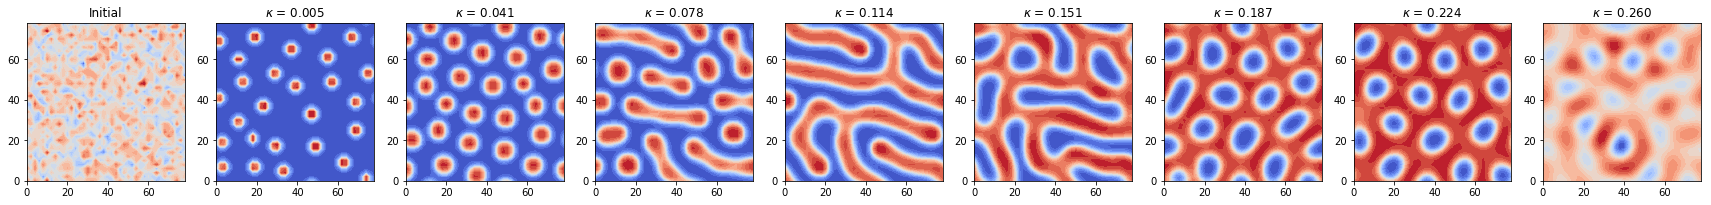

In [8]:
# Grid setup
Ny, Nx = 40, 40
h = 2
N = Nx * Ny

# Parameters setup
Du = 0.02
Dv = 2
rho = 0.001
rho_u = 0.001
mu_u = 0.02
mu_v = 0.03
kappa_arr = np.linspace(0.005, 0.26, 8)

# Time steps
dt = 20
end_t = 10000
time_steps = int(end_t / dt)
c = dt / (h * h)

# Construct transform matrices
D2x = sparse.diags([-2, 1, 1, 1, 1], [0, 1, -1, 1 - Nx, -1 + Nx], shape=(Nx, Nx))
D2y = sparse.diags([-2, 1, 1, 1, 1], [0, 1, -1, 1 - Ny, -1 + Ny], shape=(Ny, Ny))
Tu_x = sparse.eye(Nx) - 0.5 * Du * c * D2x
Tu_y = sparse.eye(Ny) - 0.5 * Du * c * D2y
Tv_x = sparse.eye(Nx) - 0.5 * Dv * c * D2x
Tv_y = sparse.eye(Ny) - 0.5 * Dv * c * D2y

# Factorize matrices
solve_Tu_x = linalg.factorized(Tu_x.tocsc())
solve_Tu_y = linalg.factorized(Tu_y.tocsc())
solve_Tv_x = linalg.factorized(Tv_x.tocsc())
solve_Tv_y = linalg.factorized(Tv_y.tocsc())

# Initial conditions
U_init = np.random.normal(0.5, 0.1, (Ny, Nx))
V_init = 0.1 * np.ones((Ny, Nx))

# The array that records each ending state with the specific parameter value
U_ends = np.zeros((len(kappa_arr)+1, Ny, Nx))
U_ends[0] = np.copy(U_init)

# The array of all plots' titles
titles = []
titles.append('Initial')

# For each kappa, generate pattern and save the ending state
for idx, kappa in enumerate(kappa_arr):
    # Initial conditions
    U = np.zeros((time_steps, Ny, Nx))
    V = np.zeros((time_steps, Ny, Nx))
    U[0] = np.copy(U_init)
    V[0] = np.copy(V_init)
    
    for i in range(1, time_steps):
        # Stage one - solve along x direction
        b1U = 0.5 * Du * c * D2y.dot(U[i - 1]) + 0.5 * dt * rho/V[i - 1] * U[i - 1]**2 / (1 + kappa*U[i - 1]**2) \
            + (1 - 0.5 * dt * mu_u) * U[i - 1] + 0.5 * dt * rho_u
        b1V = 0.5 * Dv * c * D2y.dot(V[i - 1]) \
            + 0.5 * dt * rho * U[i - 1]**2 / (1 + kappa*U[i - 1]**2) + (1 - 0.5 * dt * mu_v) * V[i - 1]

        U_middle = solve_Tu_x(b1U.T)
        V_middle = solve_Tv_x(b1V.T)

        # Stage two - solve along y direction
        b2U = 0.5 * Du * c * D2x.dot(U_middle) + 0.5 * dt * rho/V_middle * U_middle**2 / (1 + kappa*U_middle**2) \
            + (1 - 0.5 * dt * mu_u) * U_middle + 0.5 * dt * rho_u
        b2V = 0.5 * Dv * c * D2x.dot(V_middle) \
            + 0.5 * dt * rho * U_middle**2 / (1 + kappa*U_middle**2) + (1 - 0.5 * dt * mu_v) * V_middle

        U[i] = solve_Tu_y(b2U.T)
        V[i] = solve_Tv_y(b2V.T)
    
    U_ends[idx + 1] = U[-1]
    titles.append(r'$\kappa$ = %.3f' % (kappa_arr[idx]))

plot_pattern_end_states(U_ends, titles, h)

**Observation**: For stability, 

- $\kappa$ $\sim$ (0.005, 0.26).

## Summary
Each parameter in the GM model should stay within its range for generating a stable pattern.  

- Diffusion rates `Du`, `Dv`:
    - when fix `Dv` = 2, `Du` $\sim$ (0.006, 0.090); 
    - when fix `Du` = 0.02, `Dv` > 0.28.
    - The diffusion rate of the activator (`Du`) should be much smaller than the the diffusion rate of the inhibitor (`Dv`). In this way, we maintained the conditions for **short-range autocatalytic process** and the **long-range inhibitory process**.


- Source density $\rho$:
    - $\rho$ $\sim$ (`1e-55`, `1e80`)
    - For stability, the source density cannot be too small or too large. If the source density is **too small**, the **effect of reaction is too small** compared to diffusion; if the source density if too large, the **effect of diffusion is too small** compared to reaction. Since we need to keep both reaction terms and diffusion terms in the pattern formation process, the source density should be within some reasonable range.


- Basic activator production rate $\rho_u$:
    - $\rho_u$ $\sim$ (0, 0.006)
    - According to Meinhardt's activator-inhibitor system, a **small activator production** rate can initiate the system at low activator concentrations, which **is a requirement for pattern formation**. The numerically tested upper range for the activator production rate is 0.006 in our experiment.


- Decay rates of the activator ($\mu_u$) and the inhibitor ($\mu_v$):
    - when fix $\mu_v$ = 0.03, $\mu_u$ $\sim$ (0.015, 0.040)
    - when fix $\mu_u$ = 0.02, $\mu_v$ $\sim$ (0.012, 0.047)
    - According to Meinhardt's activator-inhibitor system, in order to generate a stable pattern, the decay rate of the inhibitor should be larger than the decay rate of the activator ($\mu_v > \mu_u$). Based on our experiments, the **difference between the two decay rates cannot be too large**. If the condition that $\mu_v > \mu_u$ is satisfied, the pattern will be stripes. Otherwise, some pattern can still form, but will be mostly spots. 


- Saturation constant $\kappa$:
    - $\kappa$ $\sim$ (0.005, 0.26)
    - In general, the saturation constant controls **the range of the non-linear reaction terms**. To get stable patterns, a **large range of the non-linear reaction terms is required**. A large saturation constant renders a small range for the non-linear reaction terms, which will prevent stable patterns to form. Based on our experiments, the saturation constant could be very close to zero, but cannot exceed 0.26. 
